In [1]:
!pip uninstall cello_multiplier --yes
!pip install -U git+https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git

Found existing installation: cello-multiplier 0.0.1
Uninstalling cello-multiplier-0.0.1:
  Successfully uninstalled cello-multiplier-0.0.1
  Cloning https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git to c:\users\julia\appdata\local\temp\pip-req-build-x6xfoi70
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for cello-multiplier: filename=cello_multiplier-0.0.1-py3-none-any.whl size=26280814 sha256=32f3751244f23595dbd58ba745526640e57768d868b37cde389d9b123ce5f03e
  Stored in directory: C:\Users\julia\AppData\Local\Temp\pip-ephem-wheel-cache-_ws2_8uy\wheels\4e\a2\13\7caa6e484f87d31e5fbaef2a13beef986a14a300708738afa0
Successfully built cello-multiplier


In [1]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
B_df, Z_df, labels, per_gene_mean, per_gene_std, train_dummies_specific, train_dummies_full, classifiers = cm.get_default_mats()

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
#CellO split 
from pathlib import Path
import json

split_dir = Path('data/CellO_data/bulk_RNA_seq_training_set/pretraining_validation_split/')



with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [4]:
# Load full CellO data

In [5]:
cello_data = pd.read_csv("bulk_log_tpm.tsv", sep= "\t", index_col=0).T
cello_data.head

<bound method NDFrame.head of genenames   ENSG00000000003  ENSG00000000005  ENSG00000000419  \
SRX890545          0.071963         0.068414         3.718085   
SRX1067711         0.033104         0.000000         3.743323   
SRX1067710         0.233484         0.000000         3.376271   
SRX762971          0.000000         0.000000         0.270898   
SRX762970          0.000000         0.000000         0.000000   
...                     ...              ...              ...   
SRX3399308         0.900313         0.000000         4.034299   
SRX3399309         0.317015         0.000000         3.972622   
SRX3399310         0.799190         0.000000         4.109202   
SRX3399311         0.044163         0.000000         4.007751   
SRX3399312         1.064050         0.000000         3.668019   

genenames   ENSG00000000457  ENSG00000000460  ENSG00000000938  \
SRX890545          2.184815         1.490935         6.995514   
SRX1067711         1.990195         1.780348         6.5655

## Training of LR using CellO split

In [6]:
train_Y_df = cello_data[cello_data.index.isin(train_egs)]
train_Y_df.shape

(3609, 58243)

In [7]:
test_Y_df = cello_data[cello_data.index.isin(validation_egs)]
test_Y_df.shape

(684, 58243)

In [8]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }



mlb = MultiLabelBinarizer()
types_per_b_samples = cello_data.index.map(sample2types).values

samples_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=cello_data.index)

celltypes = samples_dummies.columns.tolist()

types_sizes = samples_dummies.sum() # no of times a celltype occours in the dataset

In [9]:
target = samples_dummies["B cell"]
    
target_train = target[target.index.isin(train_egs)]

In [10]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type


def set_target(celltype,samples_dummies, train_Y_df, test_Y_df):
    
    target = samples_dummies[celltype]
    
    target_train = target[target.index.isin(train_egs)]
    target_test = target[target.index.isin(validation_egs)]
    
    train_Y_transformed = train_Y_df
    test_Y_transformed =test_Y_df
    
    return(target_train.values, target_test.values, train_Y_transformed, test_Y_transformed )

In [11]:
def fscore(p, r):
    denom = p + r or 1

    return 2*(p * r) / denom

In [12]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [13]:
types_with_data = types_sizes.index.values # all celltypes that occour in the data
all_types = samples_dummies.columns # get list of celltypes

In [17]:
from datetime import datetime
import os




def LR_classify(solver,penalty):

    #warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning
    now = datetime.now()

    date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
    outputdir = "output"
    path = os.path.join(outputdir, date_time)
    os.mkdir(path)
    
    
    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []
    aps = []
    for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, samples_dummies, train_Y_df, test_Y_df
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = penalty,
                random_state=111,C= 0.0006,tol=1e-9,intercept_scaling= 1000.0, max_iter = 1000 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            aps += [average_precision_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
            disp = plot_precision_recall_curve(clf, test_data, train_test)
            disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(test_pr))
            savename = cell_type.replace("/","")
            print(savename)
            plt.savefig(path+"/"+savename+".png")
            
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    ap = np.mean(aps)

    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}, average precision avg: {ap:.4f}')#
    
    return aps # returns the average precision of every successfully trained classifier

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3000)
trainindex = train_Y_df.index
testindex = test_Y_df.index
train_Y_df = pca.fit_transform(train_Y_df)
test_Y_df = pca.transform(test_Y_df)

In [18]:
train_Y_df.shape

(3609, 58243)

In [19]:
train_Y_df = pd.DataFrame(train_Y_df, index = trainindex)
test_Y_df = pd.DataFrame(test_Y_df, index = testindex)

NameError: name 'trainindex' is not defined

B cell
CD14-positive monocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD14-positive, CD16-negative classical monocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD141-positive myeloid dendritic cell
CD1c-positive myeloid dendritic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD4-positive helper T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD4-positive, CD25-positive, alpha-beta regulatory T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD4-positive, CXCR3-negative, CCR6-negative, alpha-beta T cell
CD4-positive, alpha-beta T cell
CD4-positive, alpha-beta memory T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD7-negative lymphoid progenitor OR granulocyte monocyte progenitor
CD8-positive, alpha-beta T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CD8-positive, alpha-beta memory T cell
CNS neuron (sensu Vertebrata)


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Kupffer cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sertoli cell
T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


T-helper 2 cell
alpha-beta T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alveolar macrophage


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


androgen binding protein secreting cell
animal cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


antibody secreting cell
anucleate cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


astrocyte
barrier cell
basal cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


basal cell of prostate epithelium
biogenic amine secreting cell
blood cell
blood vessel endothelial cell
bone cell
bone marrow cell
bone marrow hematopoietic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cell in vitro


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


central memory CD4-positive, alpha-beta T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


central nervous system macrophage
central nervous system neuron
ciliated cell
circulating cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


class switched memory B cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classical monocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


columnarcuboidal epithelial cell
connective tissue cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contractile cell
conventional dendritic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cultured cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


cumulus cell
defensive cell
dendritic cell
dendritic cell, human


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


duct epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


early embryonic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ecto-epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


effector T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


effector memory CD4-positive, alpha-beta T cell
electrically active cell
electrically responsive cell
electrically signaling cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


embryonic cell
endo-epithelial cell
endocrine cell
endopolyploid cell
endothelial cell
endothelial cell of umbilical vein
endothelial cell of vascular tree
enteroendocrine cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epidermal cell
epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epithelial cell of alveolus of lung
epithelial cell of lung
epithelial cell of pancreas


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epithelial cell of prostate


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epithelial cell of upper respiratory tract
epithelial fate stem cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


erythrocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


erythroid lineage cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


experimentally modified cell in vitro


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


extraembryonic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


female germ cell
fibroblast
follicular cell of ovary
gamete


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


general ecto-epithelial cell
germ cell
germ line cell
germinal center B cell
glandular epithelial cell
glial cell
glial cell (sensu Vertebrata)


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


glucagon secreting cell
granulocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


granulocyte monocyte progenitor cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


granulocytopoietic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


granulosa cell
group 1 innate lymphoid cell
haploid cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


helper T cell
hematopoietic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hematopoietic lineage restricted progenitor cell
hematopoietic oligopotent progenitor cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hematopoietic oligopotent progenitor cell, lineage-negative
hematopoietic precursor cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hematopoietic stem cell
hepatocyte
innate lymphoid cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


insulin secreting cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


keratin accumulating cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


keratinizing barrier epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


keratinocyte
leukocyte
lining cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


luminal cell of prostate epithelium


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


lung secretory cell
lymphocyte
lymphocyte of B lineage


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


macroglial cell
macrophage
male gamete
male germ cell
mammary gland epithelial cell
mature B cell
mature T cell
mature alpha-beta T cell
mature neutrophil


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


megakaryocyte-erythroid progenitor cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


melanocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


memory B cell
memory T cell
meso-epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mesothelial cell
metabolising cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


microglial cell
monocyte
mononuclear cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mononuclear cell of bone marrow
motile cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


muscle cell
muscle precursor cell
myeloid cell
myeloid dendritic cell
myeloid dendritic cell, human
myeloid leukocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


myeloid lineage restricted progenitor cell
myoblast


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


naive B cell
naive T cell
naive thymus-derived CD4-positive, alpha-beta T cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


naive thymus-derived CD8-positive, alpha-beta T cell
natural killer cell
neural cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


neurecto-epithelial cell
neuron


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


neuron associated cell
neutrophil


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


non-striated muscle cell
non-terminally differentiated cell
nongranular leukocyte
nucleate cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


oocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


oxygen accumulating cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pancreatic A cell
pancreatic endocrine cell
peptide hormone secreting cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pericyte cell
peripheral blood mononuclear cell
phagocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pigment cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


plasmablast
plasmacytoid dendritic cell
platelet


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


pneumocyte
polyploid cell
precursor cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


primordial germ cell
professional antigen presenting cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


promyelocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


protein secreting cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


regulatory T cell
respiratory basal cell
respiratory epithelial cell
secretory cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


seminiferous tubule epithelial cell
serotonin secreting cell
single fate stem cell
single nucleate cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


smooth muscle cell
somatic cell
somatic stem cell
sperm


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


spermatid


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


spermatocyte
squamous epithelial cell
stem cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


steroid hormone secreting cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


stratified epithelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


stratified squamous epithelial cell
stuff accumulating cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


supportive cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


surfactant secreting cell
tissue-resident macrophage


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trophectodermal cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trophoblast cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


type A enterocrine cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


type B pancreatic cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


type II pneumocyte


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


vascular associated smooth muscle cell
vein endothelial cell


C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


visceral muscle cell

precision: 0.5026, recall: 0.3649, f1: 0.3838, f1 micro avg: 0.4228, average precision avg: 0.3627


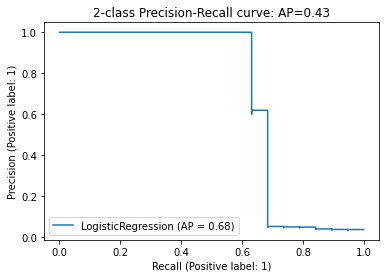

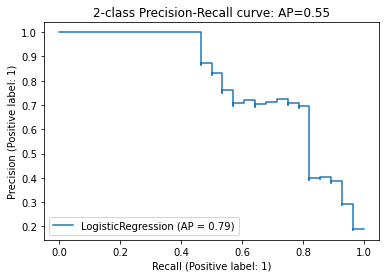

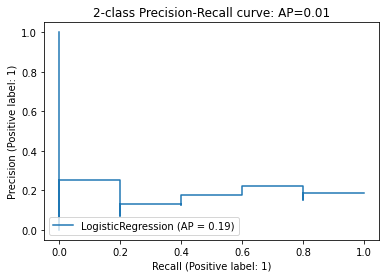

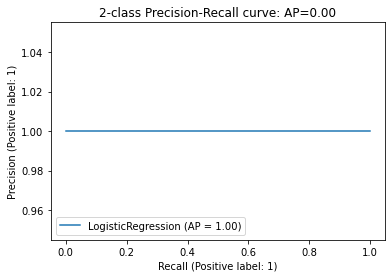

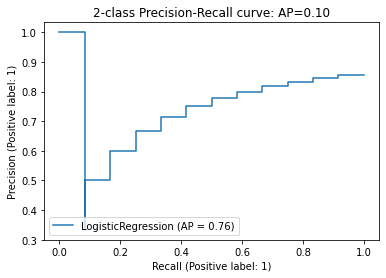

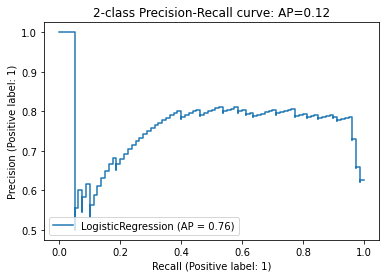

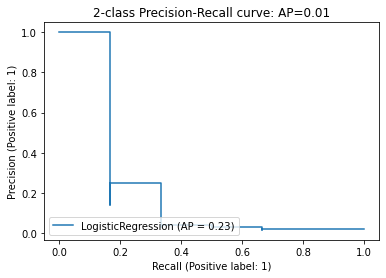

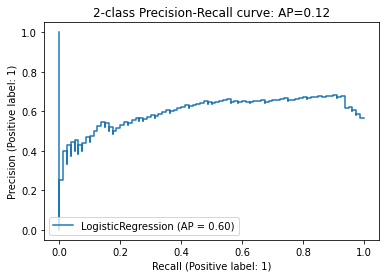

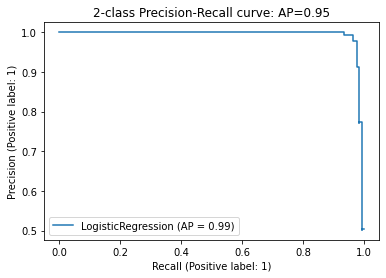

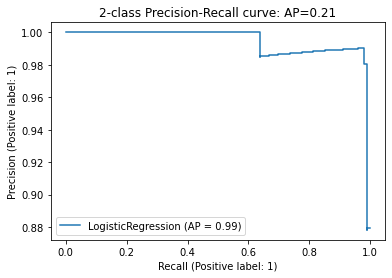

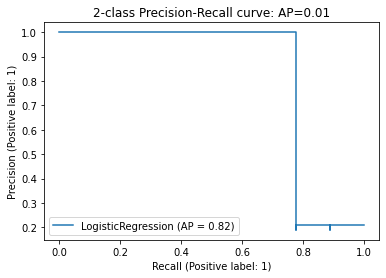

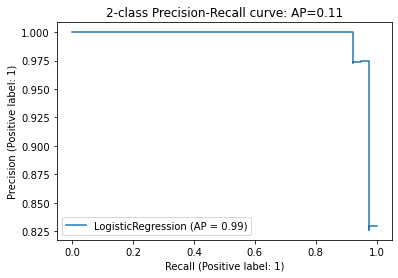

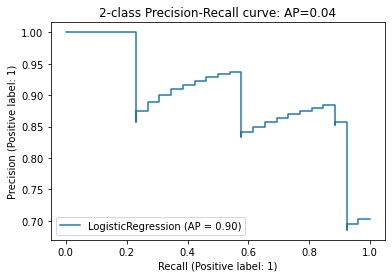

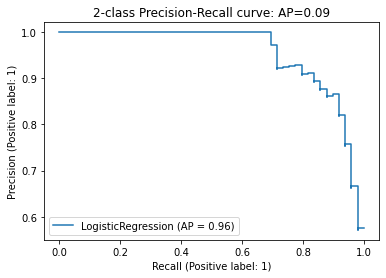

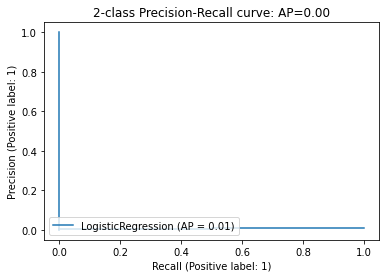

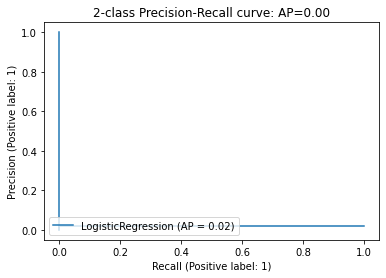

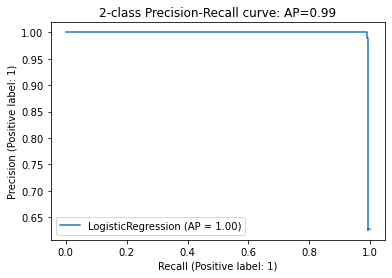

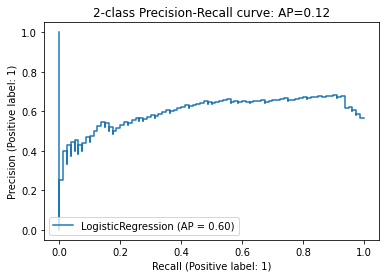

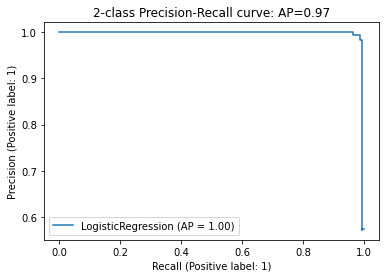

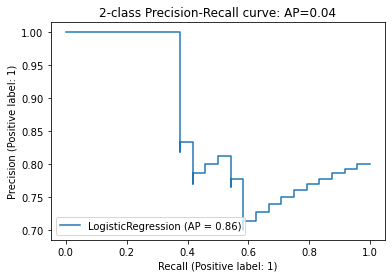

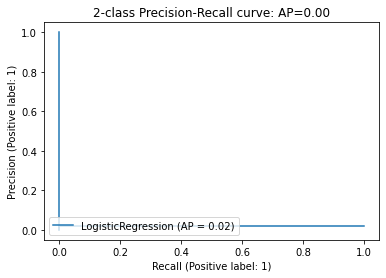

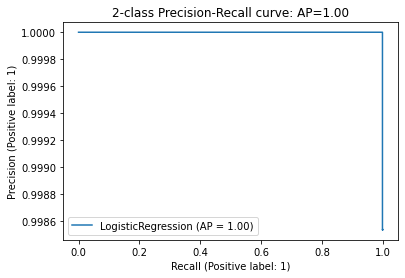

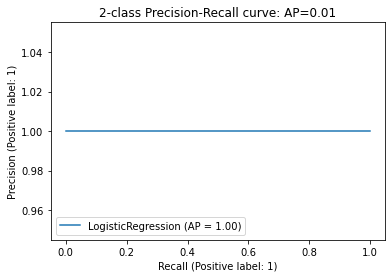

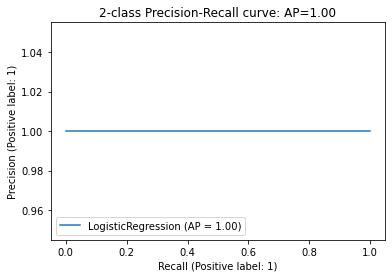

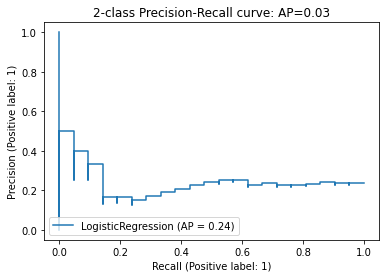

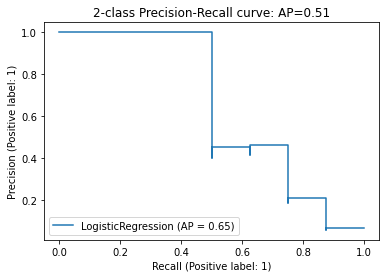

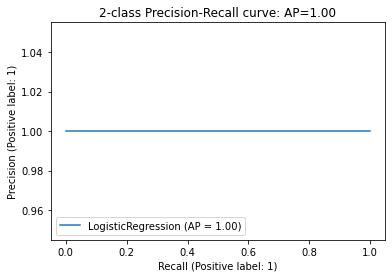

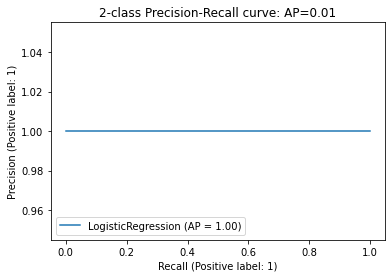

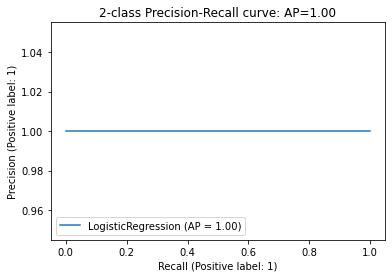

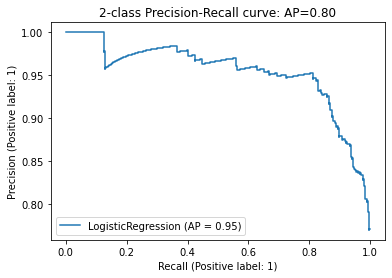

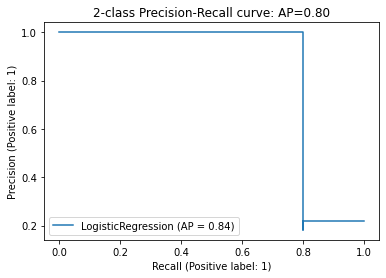

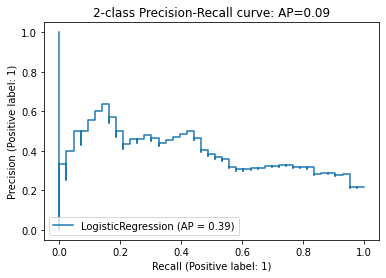

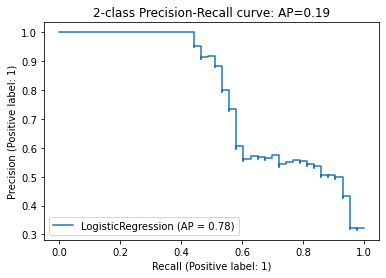

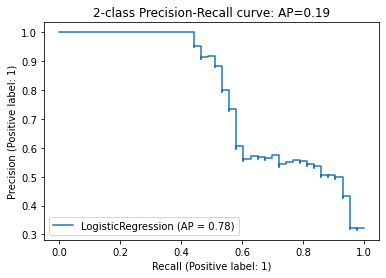

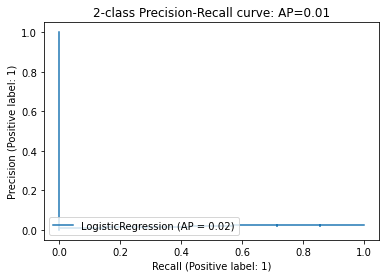

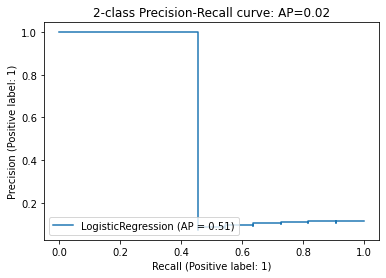

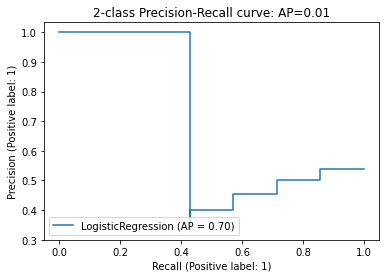

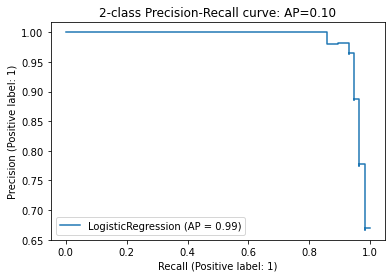

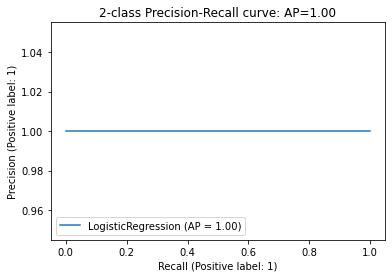

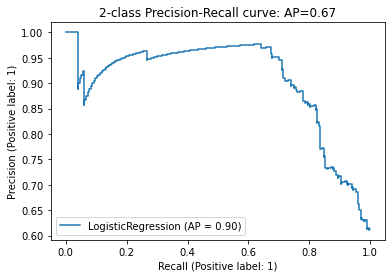

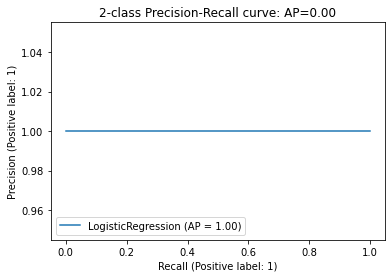

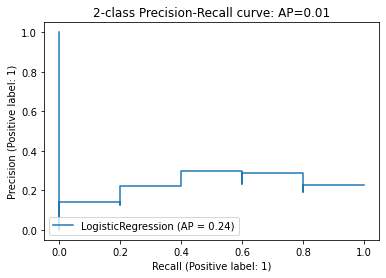

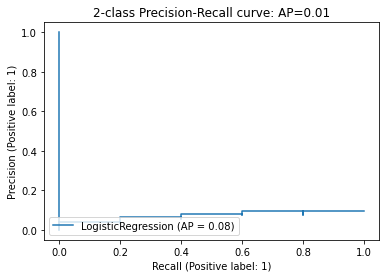

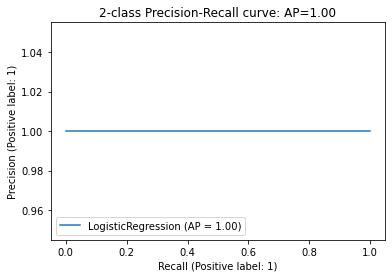

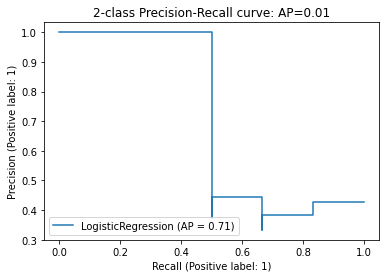

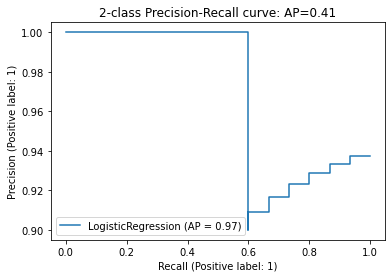

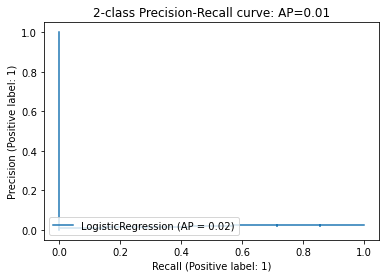

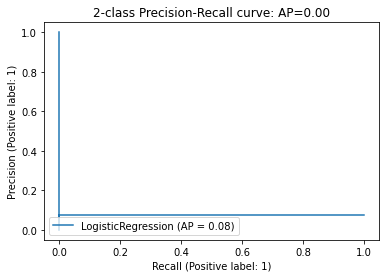

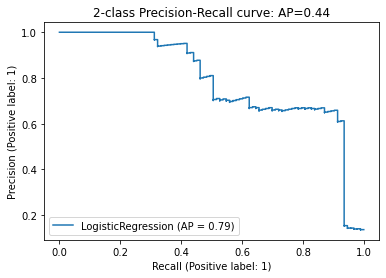

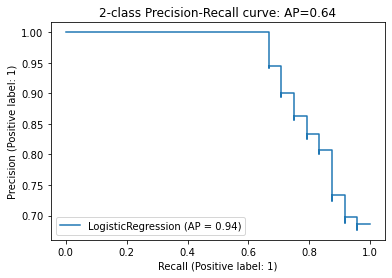

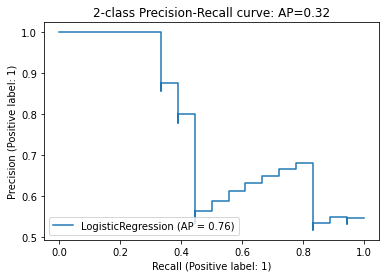

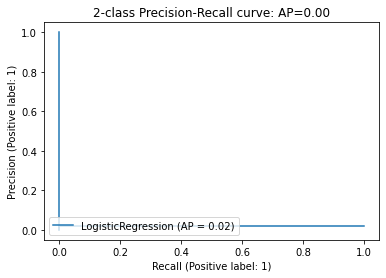

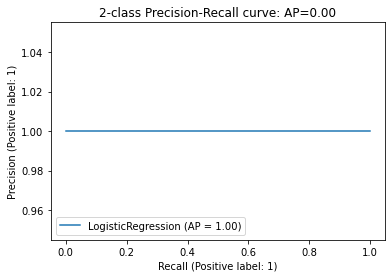

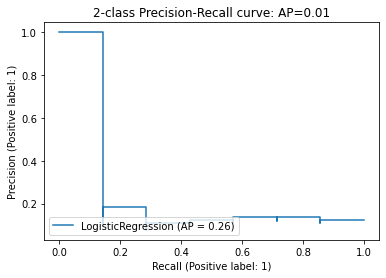

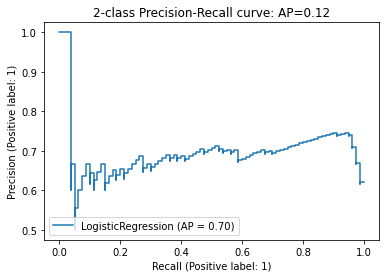

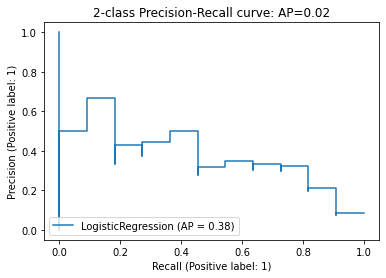

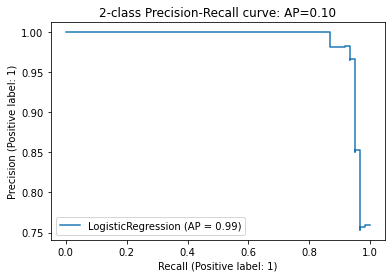

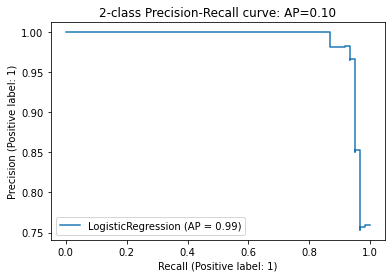

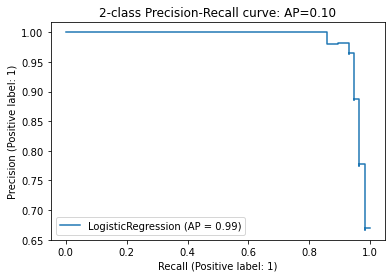

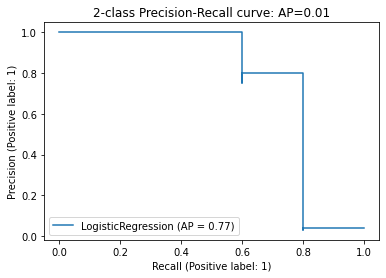

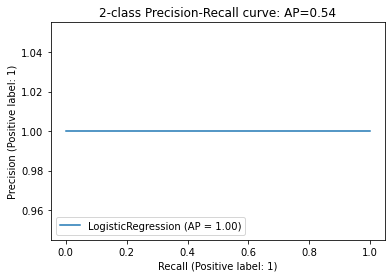

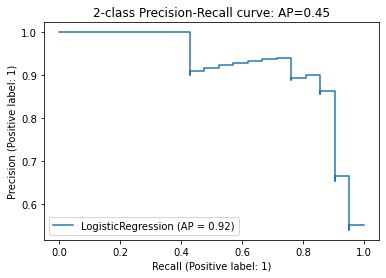

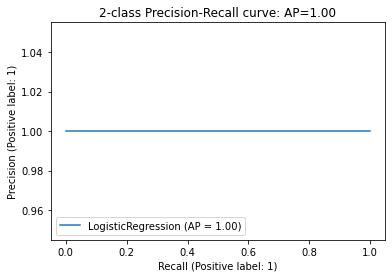

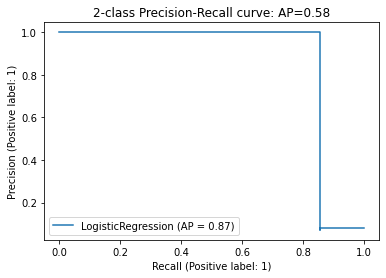

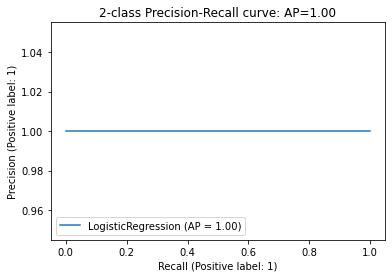

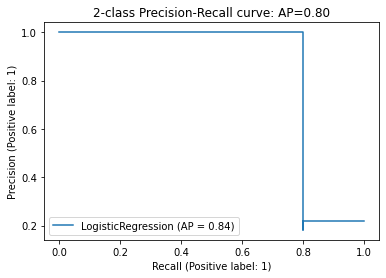

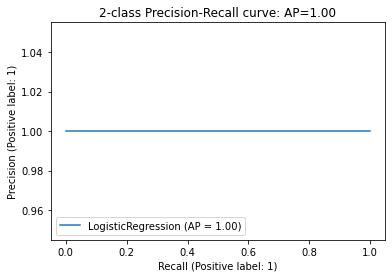

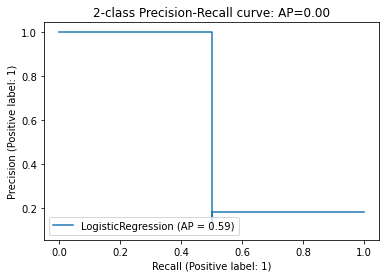

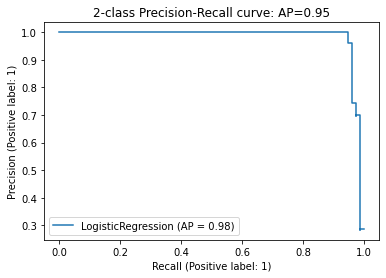

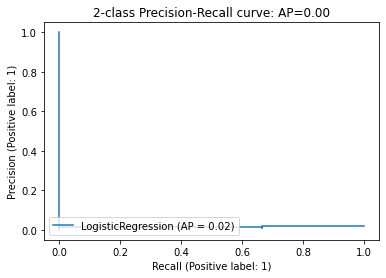

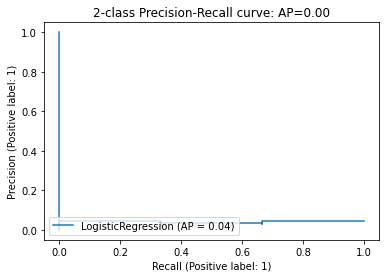

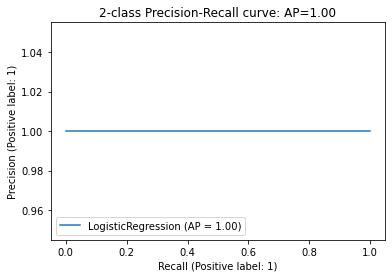

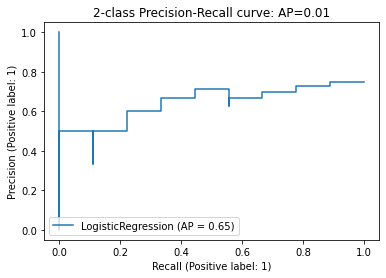

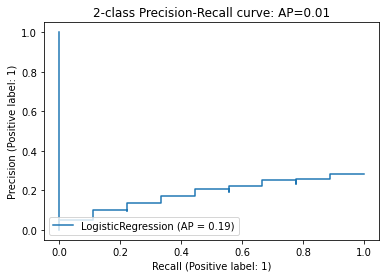

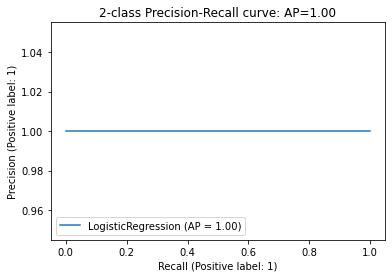

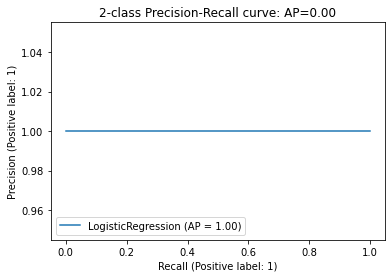

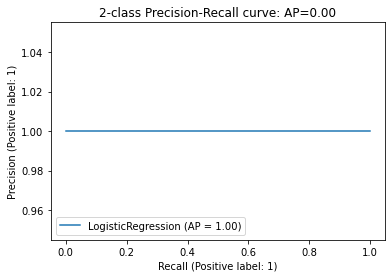

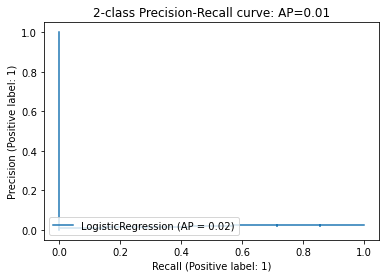

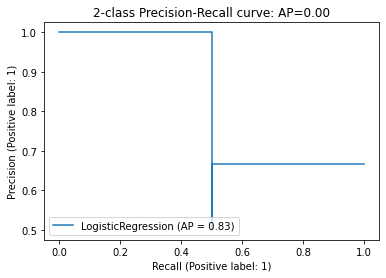

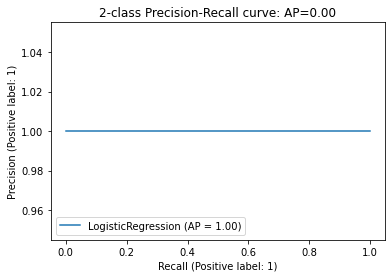

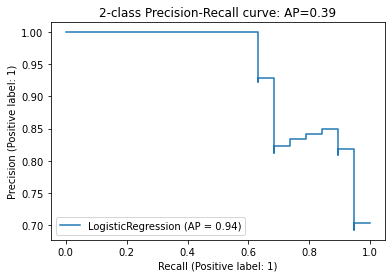

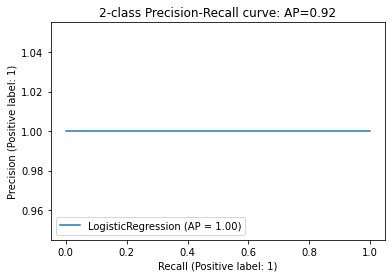

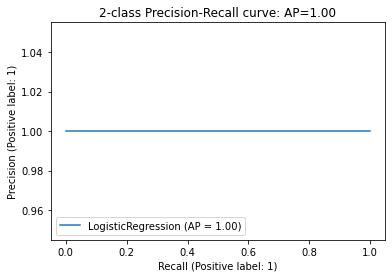

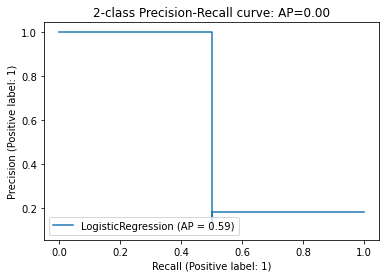

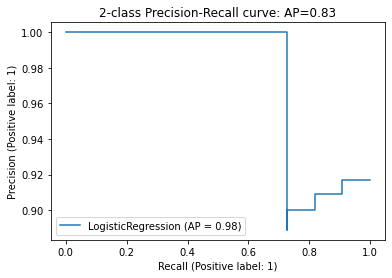

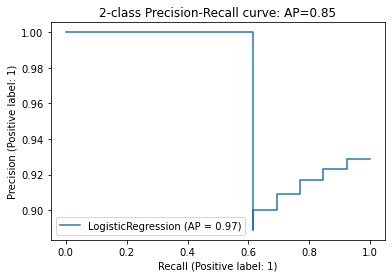

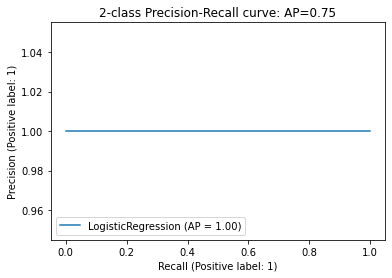

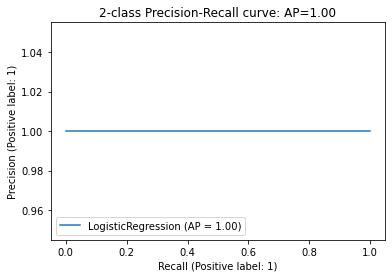

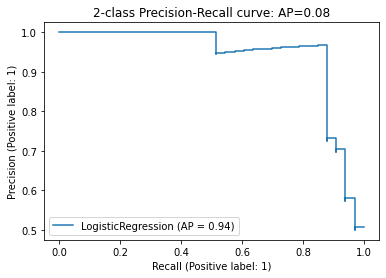

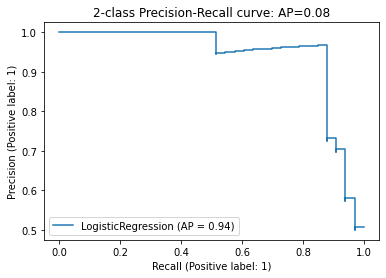

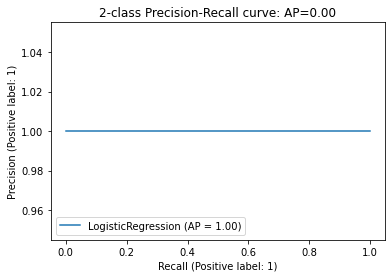

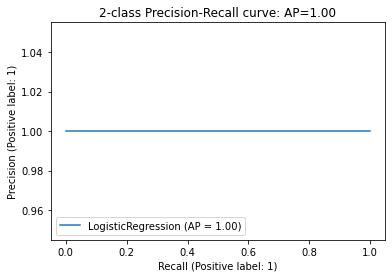

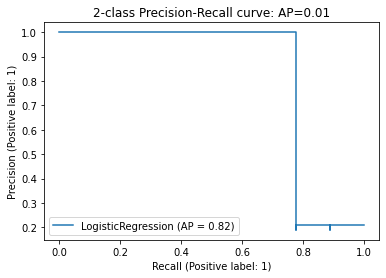

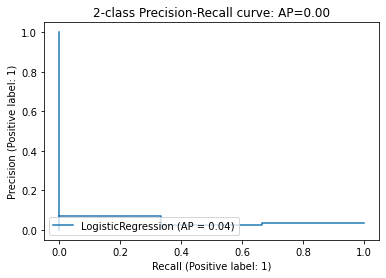

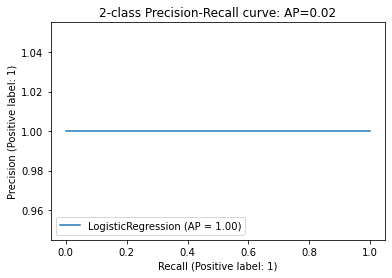

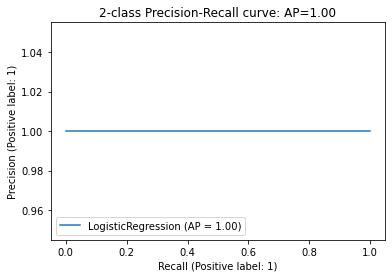

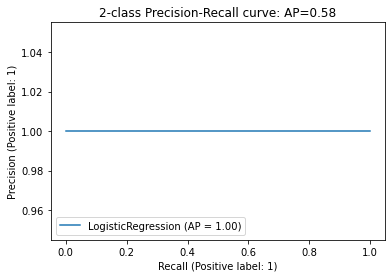

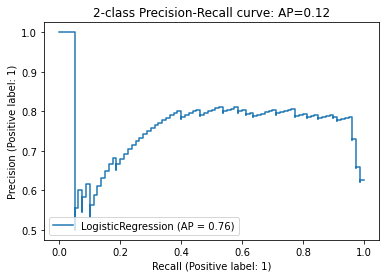

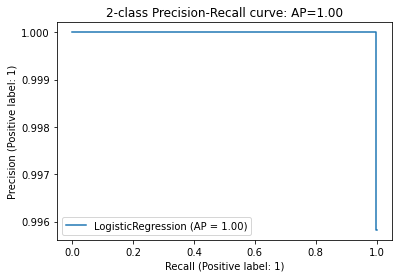

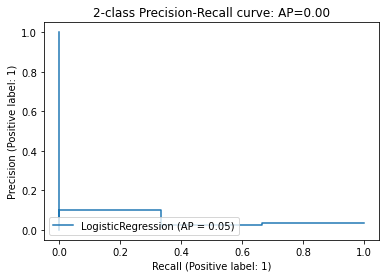

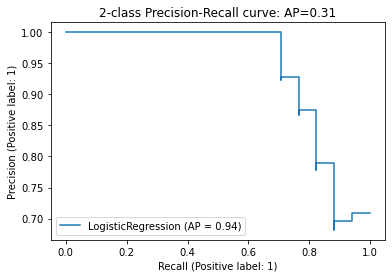

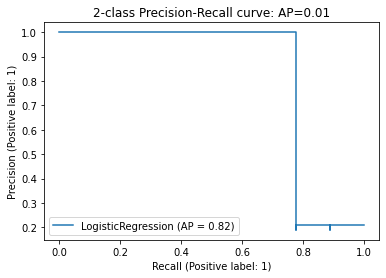

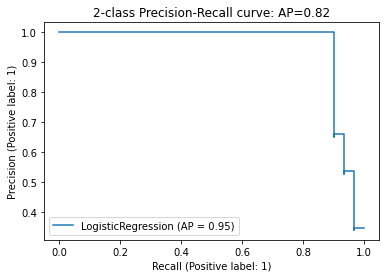

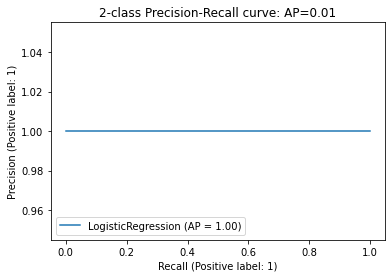

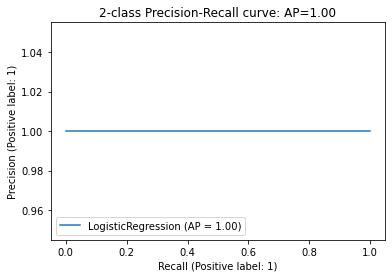

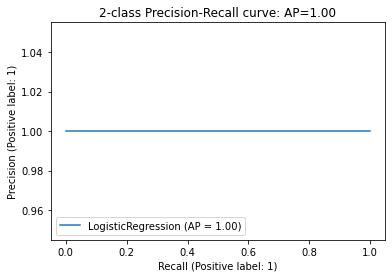

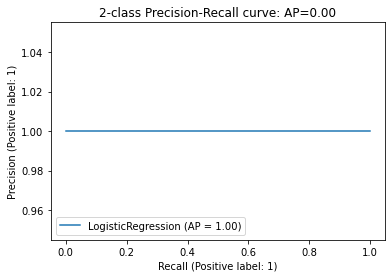

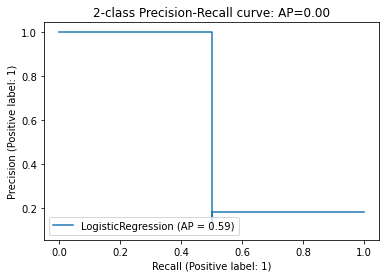

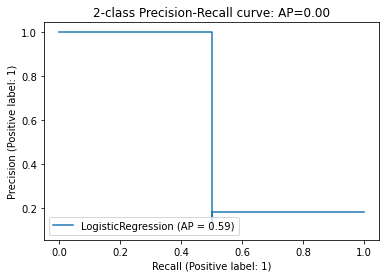

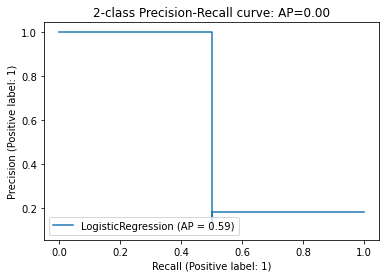

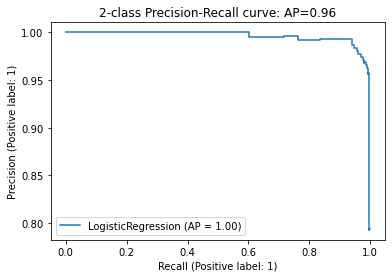

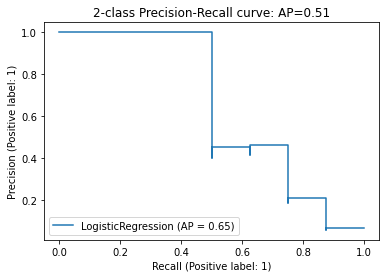

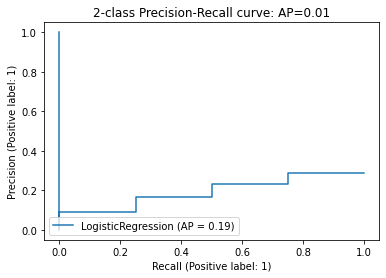

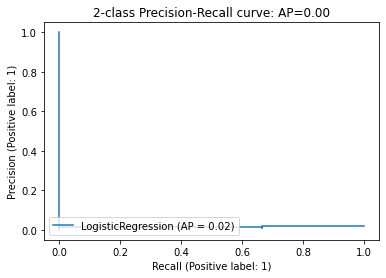

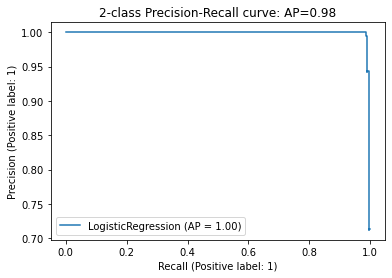

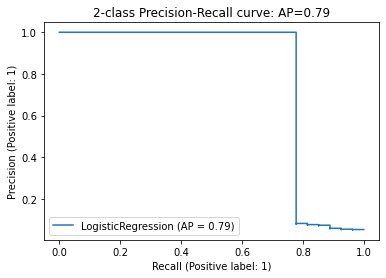

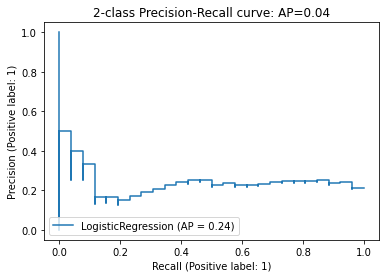

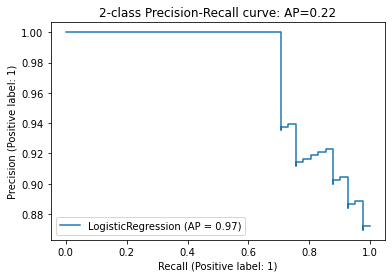

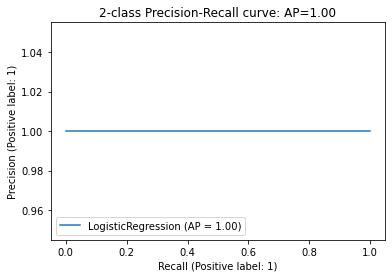

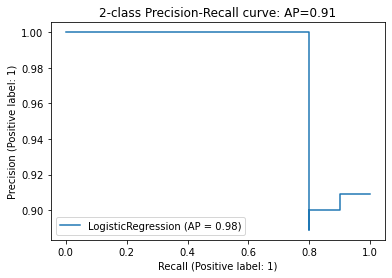

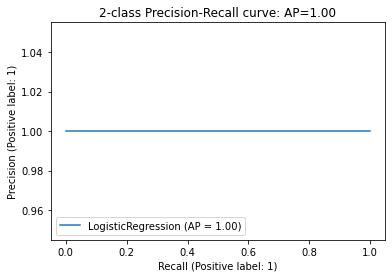

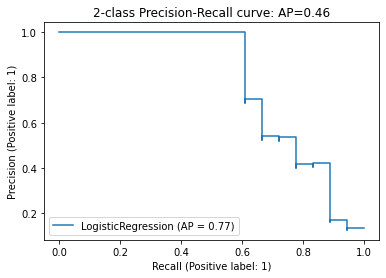

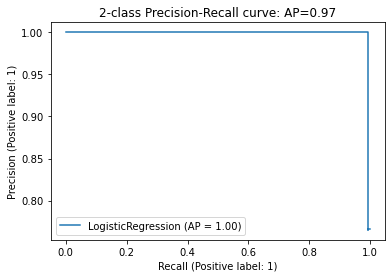

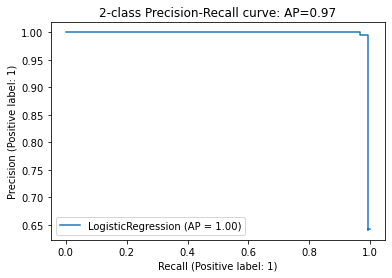

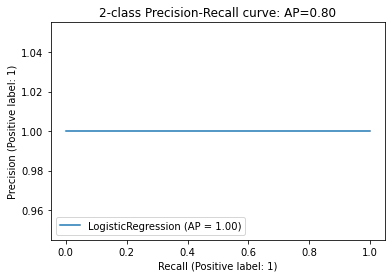

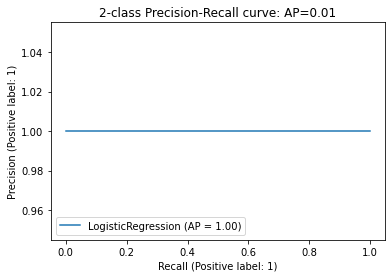

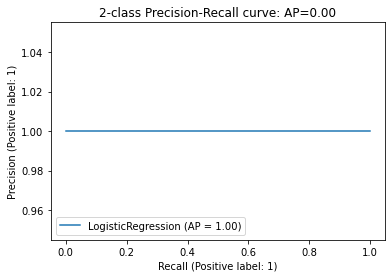

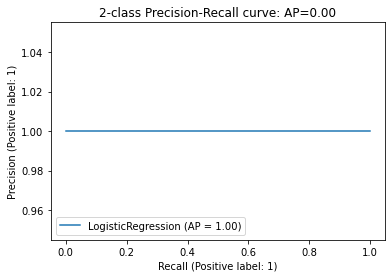

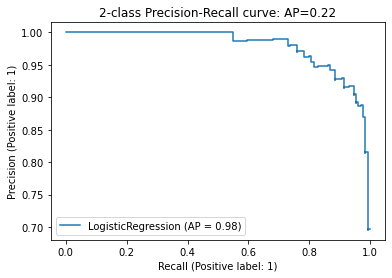

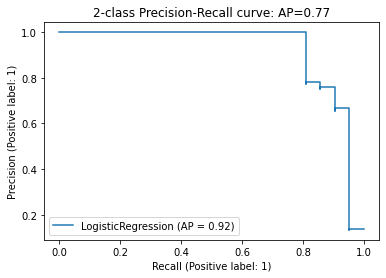

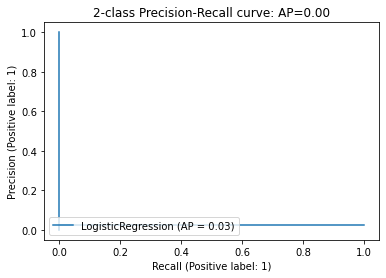

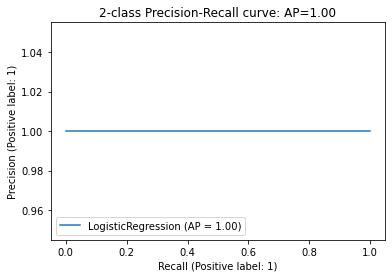

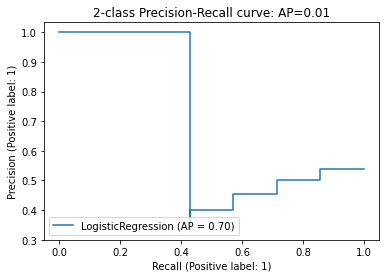

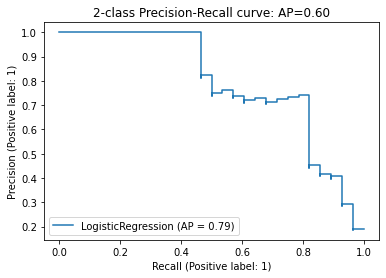

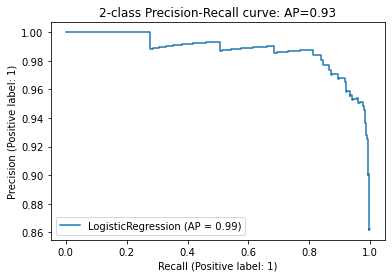

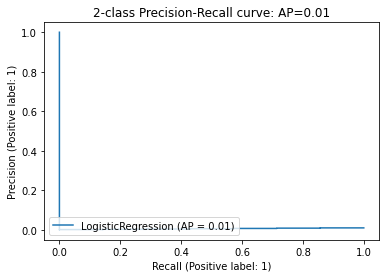

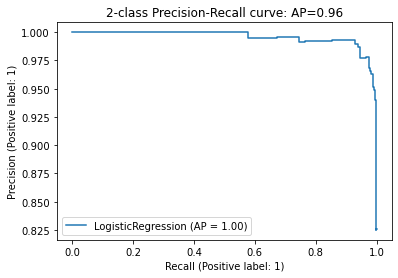

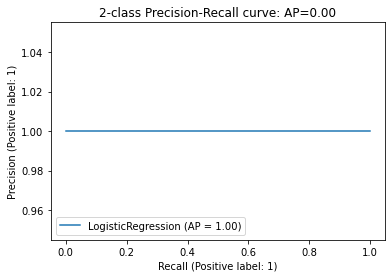

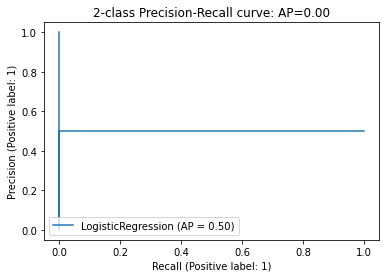

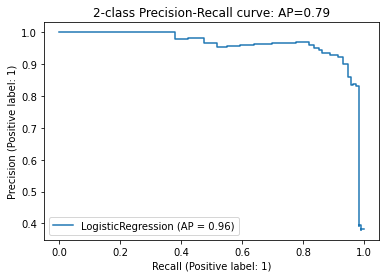

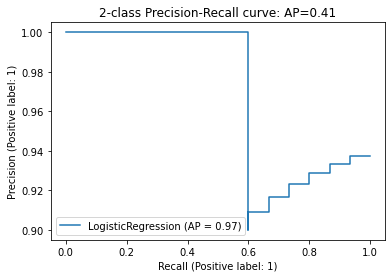

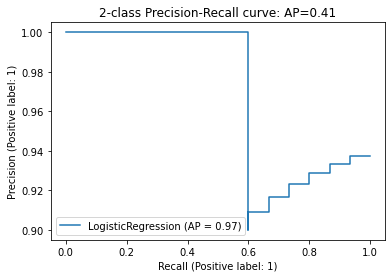

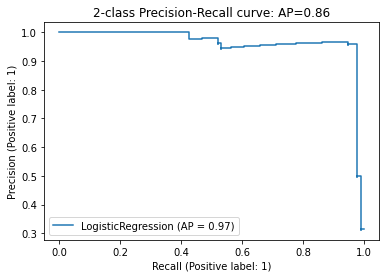

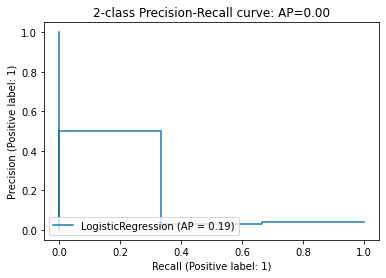

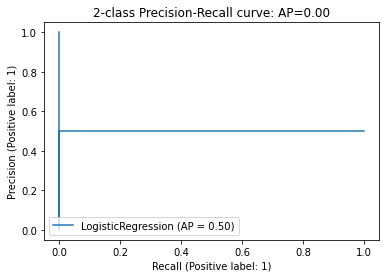

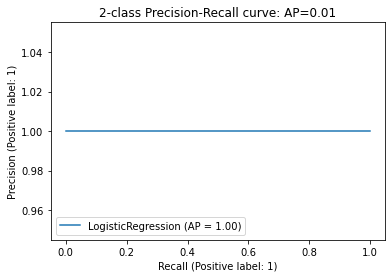

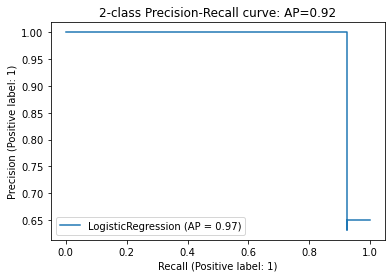

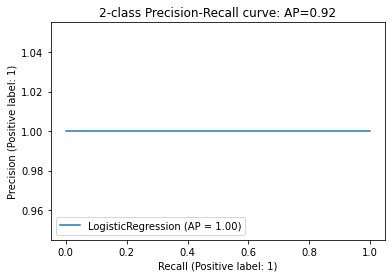

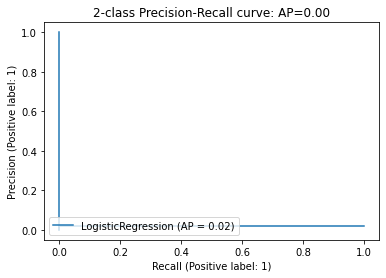

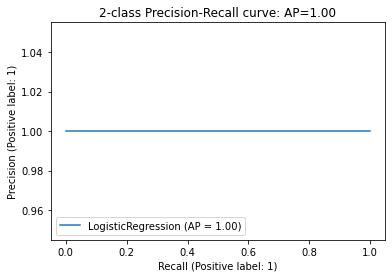

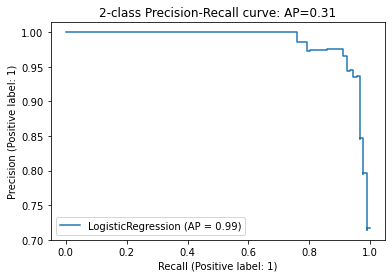

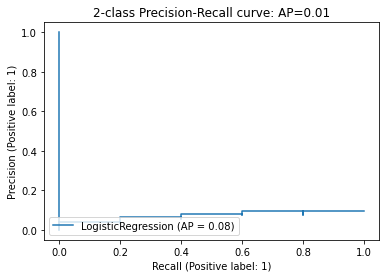

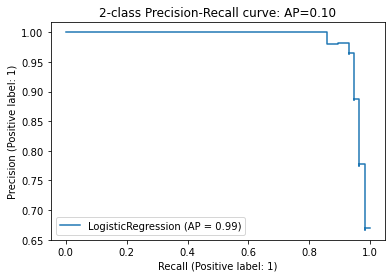

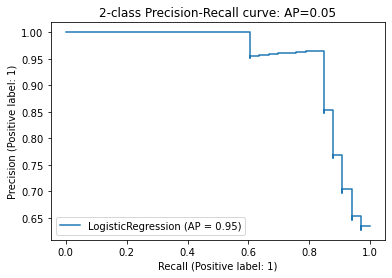

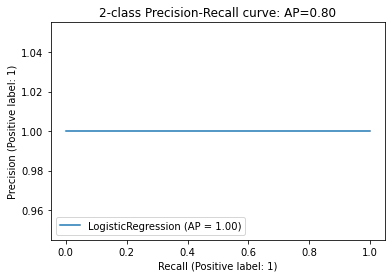

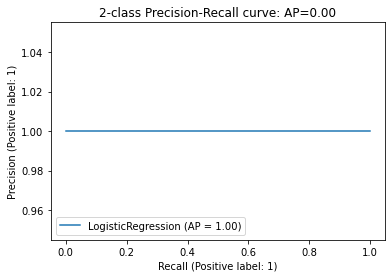

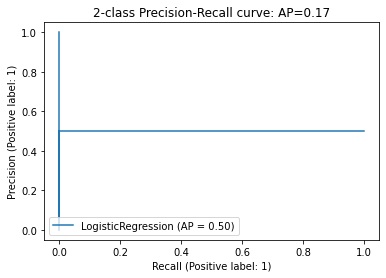

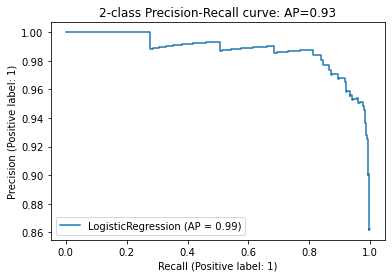

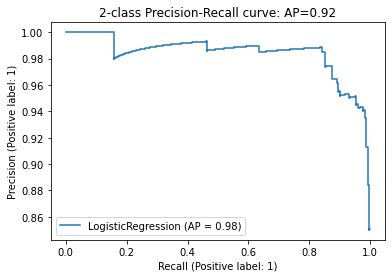

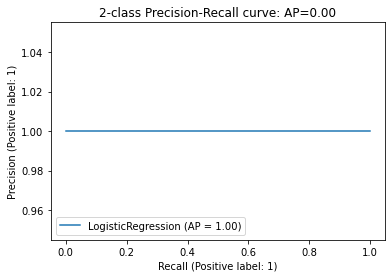

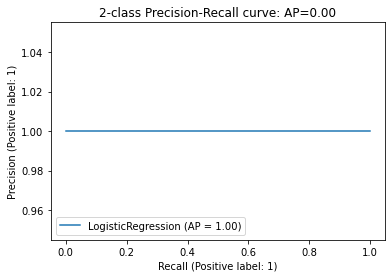

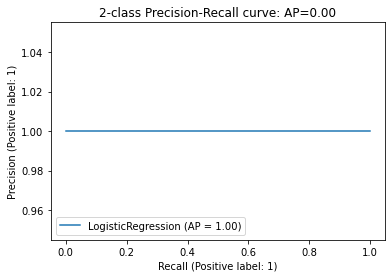

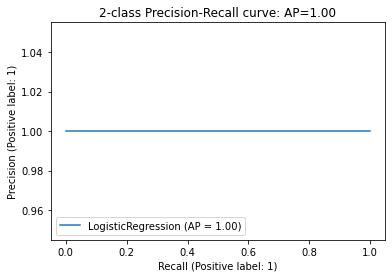

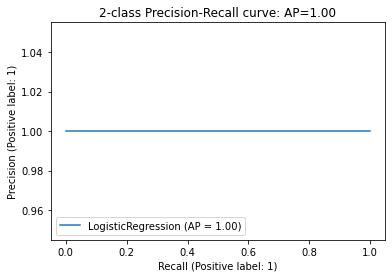

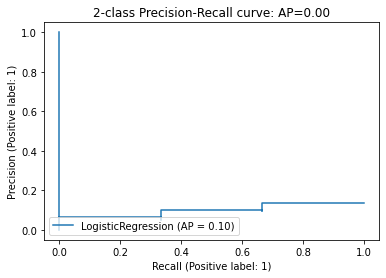

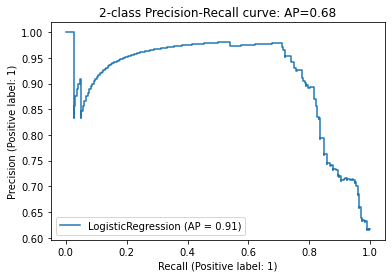

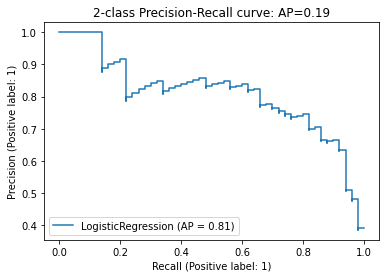

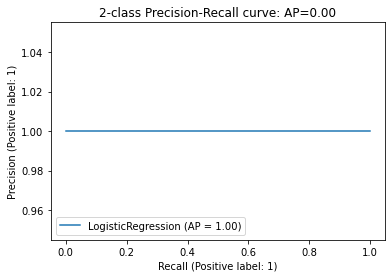

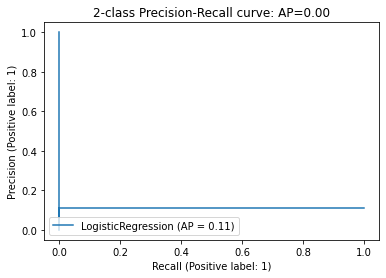

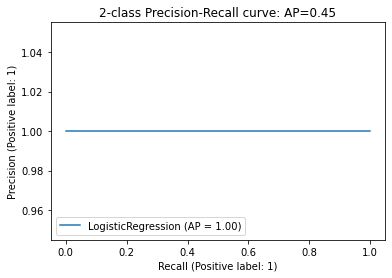

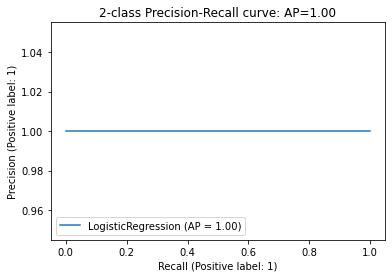

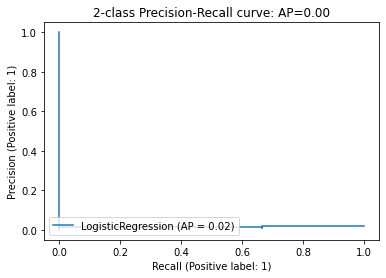

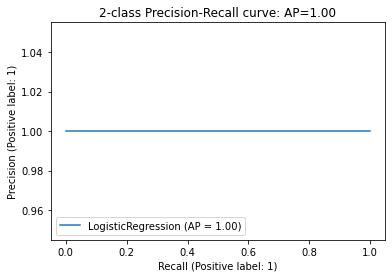

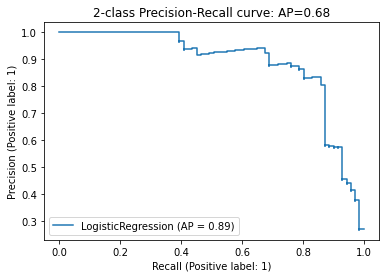

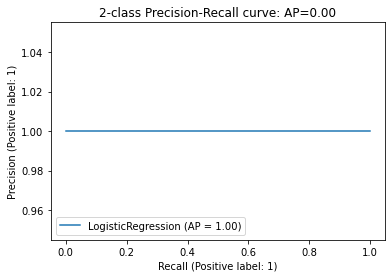

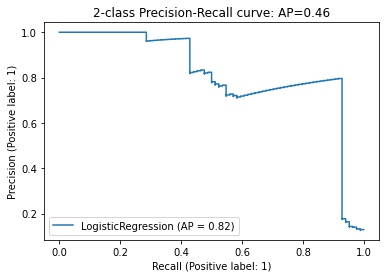

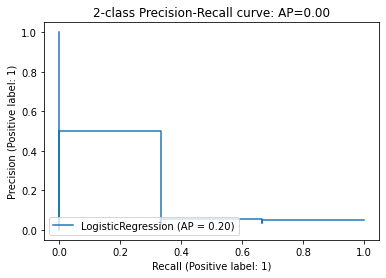

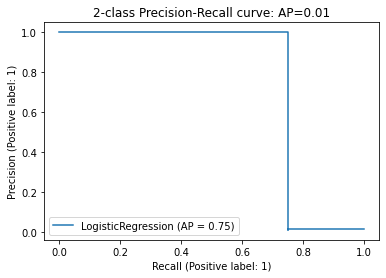

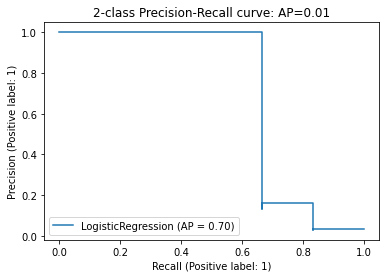

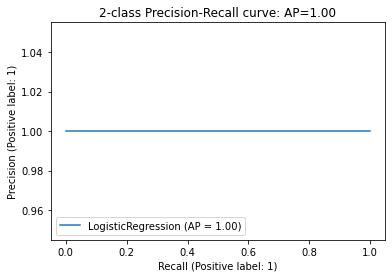

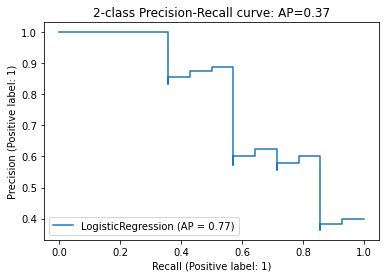

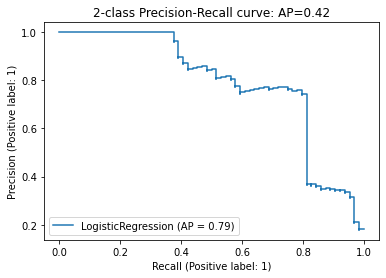

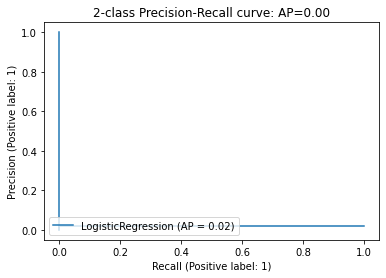

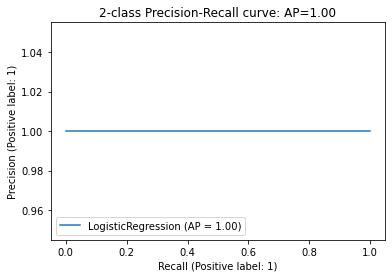

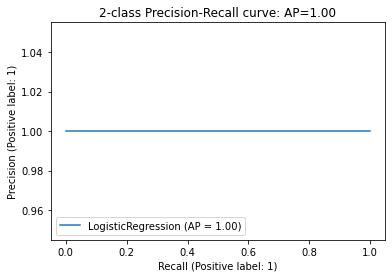

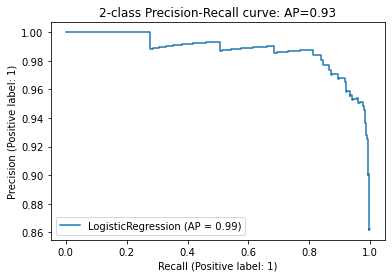

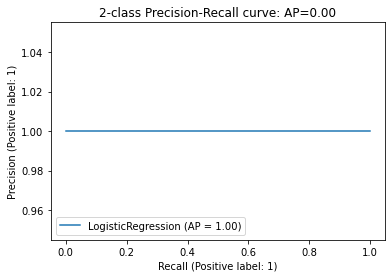

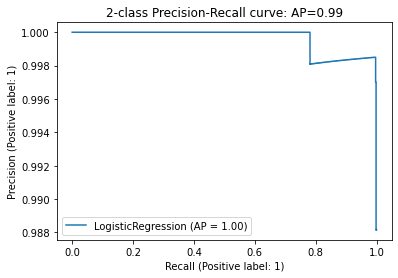

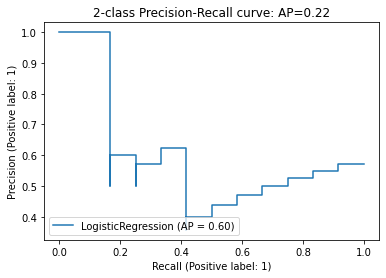

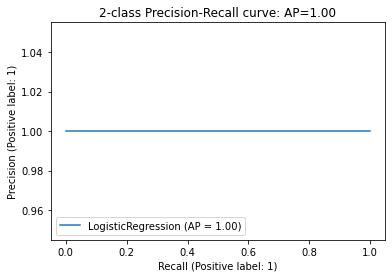

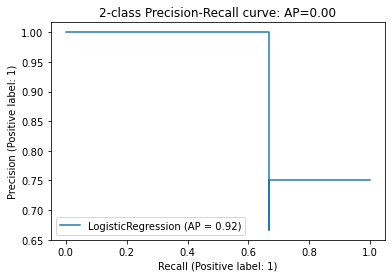

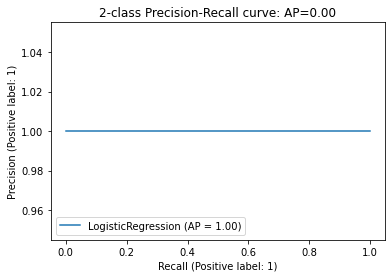

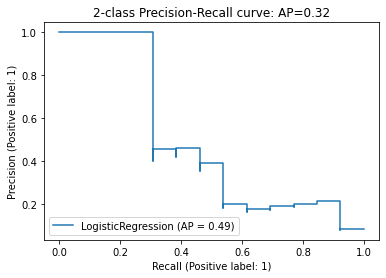

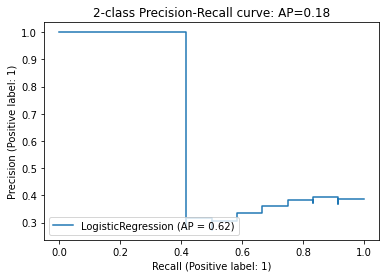

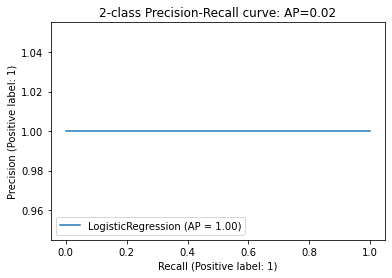

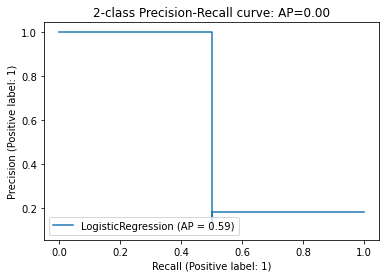

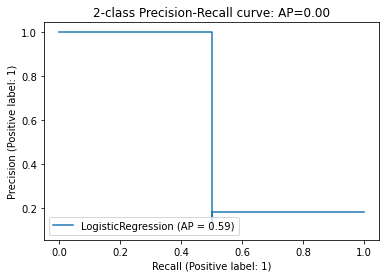

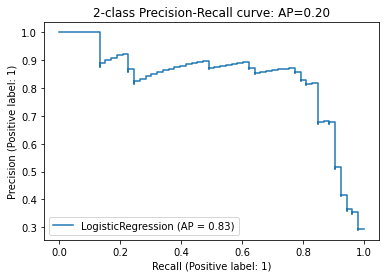

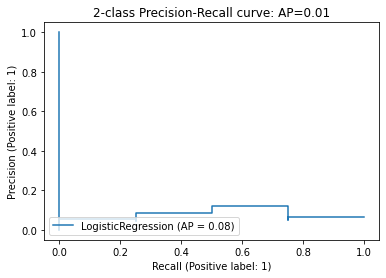

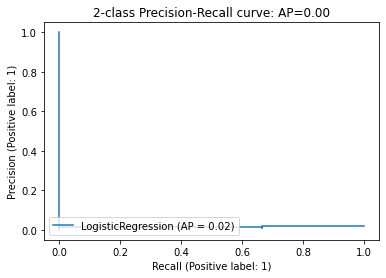

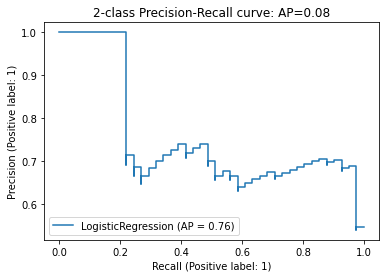

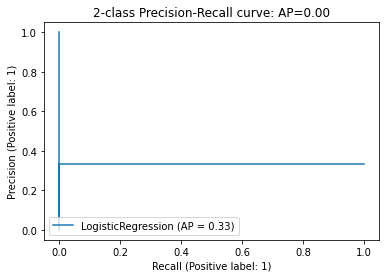

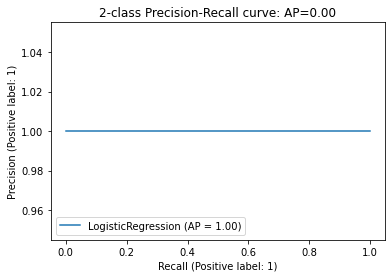

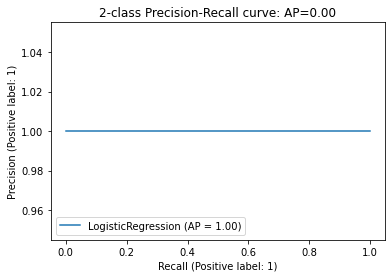

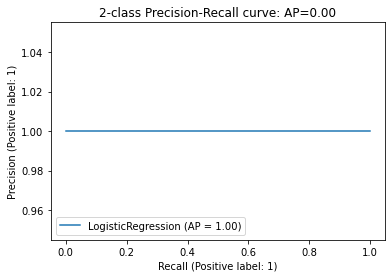

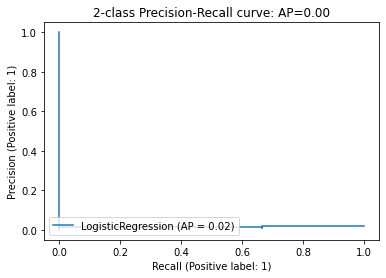

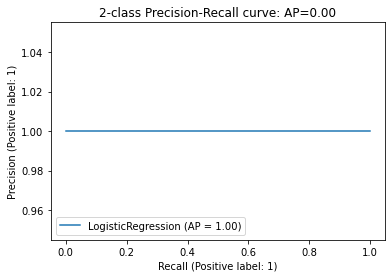

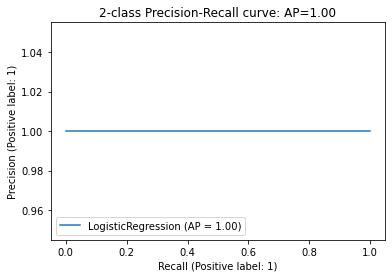

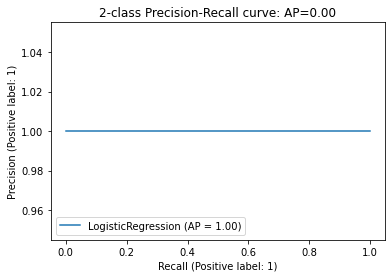

In [20]:
report = LR_classify("liblinear","l2")

<AxesSubplot:>

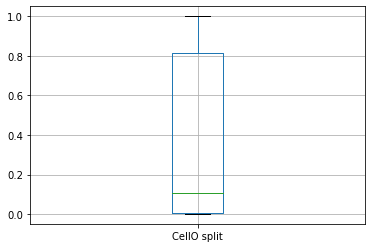

In [21]:
reportdf = pd.DataFrame(report, columns = ["CellO split"])
reportdf.boxplot()

## Training of LR using split of 30 % test data

In [64]:
from sklearn.model_selection import train_test_split
data = cello_data

In [65]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target_full(celltype, type2samples, data):
    samplelist = type2samples[celltype]
    samplelist = [x for x in samplelist if x in data.index.values]
    
    target = pd.Series(0,index = data.index)
    target.loc[samplelist] = 1
    
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.30, random_state=111)
    return(train_data, test_data, train_target.values, test_target.values)

In [66]:
def LR_classify_sklearn_split(solver,penalty):

    warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []
    aps = []
    for cell_type in tqdm(all_types):
        train_data, test_data, train_target, test_target = set_target_full(
            cell_type, type2samples, data
        )

        if(1 in train_target and 1 in test_target and 0 in train_target and 0 in test_target):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = penalty,random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(test_target, target_pred)
            test_precision += [precision_score(test_target, target_pred)]
            test_recall += [recall_score(test_target, target_pred)]
            aps += [average_precision_score(test_target, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
           
            
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    ap = np.mean(aps)

    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}, average precision avg: {ap:.4f}')#
    
    return aps # returns the average precision of every successfully trained classifier

In [67]:
report1 = LR_classify_sklearn_split("liblinear","l1")


precision: 0.8804, recall: 0.8468, f1: 0.8512, f1 micro avg: 0.8633, average precision avg: 0.8136


<AxesSubplot:>

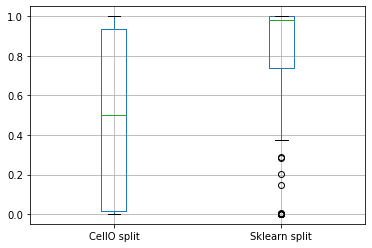

In [68]:
reportdf = pd.DataFrame(list(zip(report,report1)), columns = ["CellO split","Sklearn split"])
reportdf.boxplot()